#ST10072411 
#Developed by: Brice Agnew
#25/9/2025

This project is to be a hybrid Stylometric Neural Network (using LSTM architecture) and a 'Retrieval Augmented Generation' (RAG) Chatbot program, 
designed to identify the style of writing from given inputs, and interact with the user in fun and harmless ways

The problem proposed, that being predicting a label (Author/style) based on nominal or ordinal data(Text input/literature excerpts), seems to inherently be a classification problem, and thus LSTM model was deemed ideal for usage.





In [1]:
pip show pyspark

Name: pyspark
Version: 3.2.1
Summary: Apache Spark Python API
Home-page: https://github.com/apache/spark/tree/master/python
Author: Spark Developers
Author-email: dev@spark.apache.org
License: http://www.apache.org/licenses/LICENSE-2.0
Location: c:\users\brice\anaconda3\envs\spark_env\lib\site-packages
Requires: py4j
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip show py4j

Name: py4j
Version: 0.10.9.3
Summary: Enables Python programs to dynamically access arbitrary Java objects
Home-page: https://www.py4j.org/
Author: Barthelemy Dagenais
Author-email: barthelemy@infobart.com
License: BSD License
Location: c:\users\brice\anaconda3\envs\spark_env\lib\site-packages
Requires: 
Required-by: pyspark
Note: you may need to restart the kernel to use updated packages.


In [3]:
from pyspark import SparkContext

if SparkContext._active_spark_context is not None:
    SparkContext._active_spark_context.stop()


In [4]:
#IMPORTS
import sys
import os
import re
import numpy as np
import pandas as pd
from importlib import metadata
import matplotlib.pyplot as plt

import random

from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import split
from pyspark.sql.functions import explode, posexplode, col, udf
from pyspark.sql.types import ArrayType, StringType 

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from sklearn.metrics.pairwise import cosine_similarity




# Path of the Python executable in the conda env
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable



os.environ["JAVA_HOME"] = r"C:/Java/jdk-11.0.28.6-hotspot"
os.environ["SPARK_HOME"] = r"C:/spark/spark-3.2.1-bin-hadoop3.2"
os.environ["HADOOP_HOME"] = r"C:/spark/spark-3.2.1-bin-hadoop3.2"
os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"

os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin;" + os.environ["SPARK_HOME"] + "/bin;" + os.environ["PATH"]



spark = SparkSession.builder \
    .appName("AuthorPrediction") \
    .master("local[*]") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .config("spark.driver.host", "127.0.0.1") \
    .config("spark.hadoop.hadoop.native.io", "false") \
    .config("spark.driver.memory", "10g")\
    .getOrCreate()





C:\Users\brice\anaconda3\envs\spark_env\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
C:\Users\brice\anaconda3\envs\spark_env\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [5]:
print("Spark version:", spark.version)
print("----")
print("Python version:", sys.version)
print("----")
print("Numpy version:", np.__version__)
print("----")
print("Pandas version:",pd.__version__)
print("----")
try:
   dist = metadata.distribution("tensorflow")
   print("Name:", dist.metadata["Name"])
   print("Tensorflow version:", dist.version)
except metadata.PackageNotFoundError:
    print("TensorFlow is not installed.")
print("----")

Spark version: 3.2.1
----
Python version: 3.10.18 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:08:55) [MSC v.1929 64 bit (AMD64)]
----
Numpy version: 1.23.5
----
Pandas version: 1.5.3
----
Name: tensorflow
Tensorflow version: 2.11.0
----


In [6]:
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: C:\Users\brice\Desktop\UNI WORK\PostGrad\Semester 2\PDANA8412\POE\Books


#SECTION 1: Data Collection & Processing

This section is primarily concerned with aggregating the literature files that have been packaged with this file, converting them into a usable format, cleaning the data and generally preparing the data to be used in both training the Long-Short Term Memory (LSTM) model, and infroming the RAG-chatbot functionality later in the program.

In [7]:
#Data Collection

#Gets the current working directory(CWD)
cwd = os.getcwd()

#This function defines the logic for loading a plain-text literary work into the pipeline (initially as list obnjects)
#for use in natural language processing and training. 
def load_books(data_dir):
    texts = []
    labels = []
    for author in os.listdir(data_dir):
        author_dir = os.path.join(data_dir, author)
        for file in os.listdir(author_dir):
            with open(os.path.join(author_dir, file), 'r', encoding='utf-8') as f:
                text = f.read()
                texts.append(text)
                labels.append(author)
    return texts, labels

texts, labels = load_books(cwd+'/Data')


In [8]:
# Concatenate all books into one big corpus, to be used in the chatbot
with open("literature_corpus.txt", "w", encoding="utf-8") as f:
    for text in texts:
        f.write(text.strip() + "\n\n")  # double newline between works


In [9]:
#Checking to see if the files are correctly loaded.


for i in range(len(labels)):
#checks the Author
    print("Book", [i], ":")
    
    print("Author:",labels[i])

# Display the first 200 characters of the text at index 'i'
    print("Text:",texts[i][:200],"...")

# Count the total number of characters in the text at index 'i'
    print("Length:",len(texts[i]))
    print()

    print("------------------------")

#In total about 20 books are used in this project

Book [0] :
Author: Austen
Text: ﻿
Northanger Abbey


by Jane Austen

(1803)




Contents


 ADVERTISEMENT BY THE AUTHORESS, TO NORTHANGER ABBEY

 CHAPTER 1
 CHAPTER 2
 CHAPTER 3
 CHAPTER 4
 CHAPTER 5
 CHAPTER 6
 CHAPTER 7
 CHAPTER 8 ...
Length: 434006

------------------------
Book [1] :
Author: Austen
Text: ﻿
Persuasion


by Jane Austen

(1818)




Contents


 CHAPTER I.
 CHAPTER II.
 CHAPTER III.
 CHAPTER IV.
 CHAPTER V.
 CHAPTER VI.
 CHAPTER VII.
 CHAPTER VIII.
 CHAPTER IX.
 CHAPTER X.
 CHAPTER XI.
 CH ...
Length: 464833

------------------------
Book [2] :
Author: Austen
Text: ﻿


                                PRIDE.
                                  and
                               PREJUDICE

                                  by
                             Jane Austen ...
Length: 728313

------------------------
Book [3] :
Author: Austen
Text: ﻿



                         Transcriber's Note:

The Table of Contents is not part of the original book. The illustration
on page 29

In [10]:
#Data Cleaning:

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove non-alphabetic characters (keep spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    return text




In [11]:
#Dataframe creation:

rows = [Row(text=text, author=label) for text, label in zip(texts, labels)]
book_df = spark.createDataFrame(rows)
book_df.show(3, truncate=200)


+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|                                                                                                                                                                                                    text|author|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|﻿\nNorthanger Abbey\n\n\nby Jane Austen\n\n(1803)\n\n\n\n\nContents\n\n\n ADVERTISEMENT BY THE AUTHORESS, TO NORTHANGER ABBEY\n\n CHAPTER 1\n CHAPTER 2\n CHAPTER 3\n CHAPTER 4\n CHAPTER 5\n CHAPTER...|Austen|
|﻿\nPersuasion\n\n\nby Jane Austen\n\n(1818)\n\n\n\n\nContents\n\n\n CHAPTER I.\n CHAPTER II.\n CHAPTER III.\n CHAPTER IV.\n CHAPTER V.\n CHAPTER VI.\n CHAPTER 

In [12]:
# Registering the 'clean_text' function as a User Defined Function
clean_text_udf = udf(lambda x: clean_text(x), StringType())

# Apply it to the 'text' column
book_df_clean = book_df.withColumn("clean_text", clean_text_udf(book_df.text))
book_df_clean.show(3)



+--------------------+------+--------------------+
|                text|author|          clean_text|
+--------------------+------+--------------------+
|﻿\nNorthanger Abb...|Austen| northanger abbey...|
|﻿\nPersuasion\n\n...|Austen| persuasion by ja...|
|﻿\n\n\n          ...|Austen| pride and prejud...|
+--------------------+------+--------------------+
only showing top 3 rows



#SECTION 2: Tokenization
#This code and the following section is necessary for rendering the data in a way that is more interpretable to machine learning algorithms 
and Neural networks.
 


In [13]:
# Splitting text into individual words
#This is necessary in order to break the literature into more managable segments, or 'chunks' in training and processing 

#this code literally splits the text based on where whitespaces are found in the text
df_tokens = book_df_clean.withColumn("tokens", split(book_df_clean.clean_text, " "))
df_tokens.show(3)

+--------------------+------+--------------------+--------------------+
|                text|author|          clean_text|              tokens|
+--------------------+------+--------------------+--------------------+
|﻿\nNorthanger Abb...|Austen| northanger abbey...|[, northanger, ab...|
|﻿\nPersuasion\n\n...|Austen| persuasion by ja...|[, persuasion, by...|
|﻿\n\n\n          ...|Austen| pride and prejud...|[, pride, and, pr...|
+--------------------+------+--------------------+--------------------+
only showing top 3 rows



In [14]:
#This section is responsible for breaking the list of words into 'chunks' in sequence, in order to better assist the LSTM and RAG programs in training 
#to the literature data

#Some tuning was involved in tbhis in order to try and raise the accuracy of the stylometric algorithm.

# Explode tokens into smaller chunks
chunk_size = 500 #=77% accuracy and 96% practical predictions
stride= 250


#Version 2
def chunk_tokens(tokens, chunk_size=chunk_size, stride=stride):
    chunks = []
    for i in range(0, len(tokens) - chunk_size + 1, stride):
        chunks.append(tokens[i:i+chunk_size])
    return chunks

# UDF (User Defined Function) for Spark
chunk_tokens_udf = udf(lambda x: chunk_tokens(x), ArrayType(ArrayType(StringType())))  #58% accuracy
# Apply chunking
df_chunks = df_tokens.withColumn("chunks", chunk_tokens_udf(col("tokens")))
# 'Explode' into rows
df_exploded = df_chunks.select(col("author"), explode(col("chunks")).alias("chunk"))
df_exploded.show(5, truncate=False)




# This section chunks the raw texts in order to present them via the chatbot
def chunk_raw_text(text, chunk_size=chunk_size, stride=stride):
    text = text.replace("\n", " ")
    chunks = []
    for i in range(0, len(text) - chunk_size + 1, stride):
        chunks.append(text[i:i+chunk_size])  # take raw slice, no .split()
    return chunks
    
chunk_raw_udf = udf(lambda x: chunk_raw_text(x), ArrayType(StringType()))

df_chunks_raw = book_df.withColumn("chunks_raw", chunk_raw_udf(col("text")))
df_exploded_raw = df_chunks_raw.select(col("author"), explode(col("chunks_raw")).alias("chunk"))


+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [15]:
# Check if spark instance exists and is active, during development this proved to be a recurring issue due to hardware limitations.
try:
    spark.version  # this will fail if spark is not active
    print("Spark session is active. Version:", spark.version)
except NameError:
    print("Spark session not defined. Please start it.")
except Exception as e:
    print("Spark session exists but not active:", e)


Spark session is active. Version: 3.2.1


In [ ]:
#Exploratory Data Analysis

In [16]:
#this section is (Obviously) used to display the current working total of chunks, both in the 'processed' text data and the 'raw' texts

# Total number of tokenized chunks
total_token_chunks = df_exploded.count()
print(f"Total number of tokenized chunks: {total_token_chunks}")

# Total number of raw text chunks
total_raw_chunks = df_exploded_raw.count()
print(f"Total number of raw text chunks: {total_raw_chunks}")




Total number of tokenized chunks: 14732
Total number of raw text chunks: 82463


In [17]:
#this displays how many chunks are attributed to different authors
df_exploded.groupBy("author").count().show()


+-----------+-----+
|     author|count|
+-----------+-----+
|     Austen| 1632|
|    Dickens| 2900|
|      Eliot| 2088|
|   Melville| 1460|
|Shakespeare| 3850|
|    Shelley| 1502|
|      Twain| 1300|
+-----------+-----+



In [18]:
#Due to imbalance concerns in training, I attempted to reduce each Author to having the same number of chunks in order to try and increase 
#'fair' generalisation.

# Smallest class size
min_count = df_exploded.groupBy("author").count().agg({"count": "min"}).collect()[0][0]

# Sample each author to the same size
balanced = df_exploded.groupBy("author").applyInPandas(
    lambda pdf: pdf.sample(n=min_count, random_state=69),
    schema=df_exploded.schema
)


In [19]:
balanced.groupBy("author").count().show()


+-----------+-----+
|     author|count|
+-----------+-----+
|    Shelley| 1300|
|     Austen| 1300|
|   Melville| 1300|
|    Dickens| 1300|
|      Eliot| 1300|
|      Twain| 1300|
|Shakespeare| 1300|
+-----------+-----+



In [20]:

# Total number of tokenized chunks
total_token_chunks = balanced.count()
print(f"Total number of balanced chunks: {total_token_chunks}")



Total number of balanced chunks: 9100


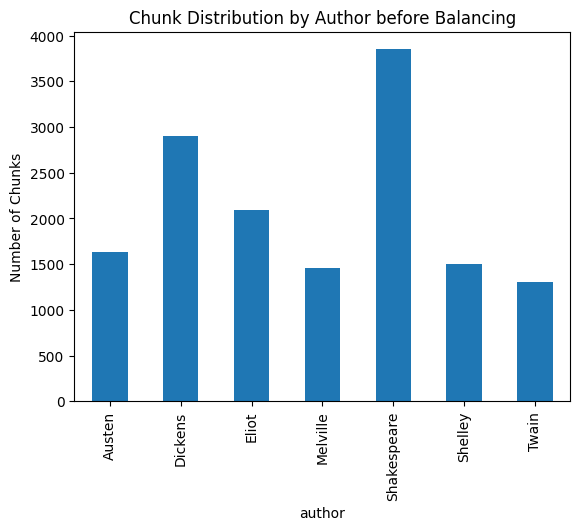

In [41]:
#Data visualisation to represent the distribution of chunks by author before balancing

author_counts = df_exploded.groupBy("author").count().toPandas()
author_counts.plot(kind='bar', x='author', y='count', legend=False)
plt.ylabel("Number of Chunks")
plt.title("Chunk Distribution by Author before Balancing")
plt.show()


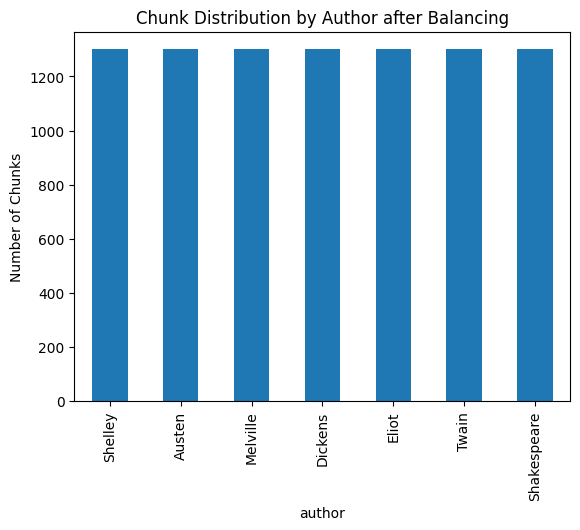

In [42]:
#Data visualisation to represent the distribution of chunks by author After balancing

author_counts = balanced.groupBy("author").count().toPandas()
author_counts.plot(kind='bar', x='author', y='count', legend=False)
plt.ylabel("Number of Chunks")
plt.title("Chunk Distribution by Author after Balancing")
plt.show()


In [23]:
#This section involves ACTUAL tokenisation

# Collect all chunks into Python list
chunks = [ " ".join(row.chunk) for row in df_exploded.collect() ]
authors = [row.author for row in df_exploded.collect()]

# Tokenize
tokenizerLSTM = Tokenizer()
tokenizerLSTM.fit_on_texts(chunks)
sequences = tokenizerLSTM.texts_to_sequences(chunks)

# Pad sequences to fixed length
max_len = 200
X = pad_sequences(sequences, maxlen=max_len)


In [24]:
#Encoding labels (Authors)

# Encode author names into integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(authors)

# One-hot encode labels (for softmax output)
y = to_categorical(y)

num_classes = y.shape[1]


#SECTION 3: Training LSTM

This section is responsible for trainign the LSTM classifier model. however, various models have already beem pretrained, and thus this code can be skipped, save for the "predict_author" function which is necessary for later processes.



In [25]:
#TRAINING


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=69, stratify=y
)


In [26]:
#Building the model:

vocab_size = len(tokenizerLSTM.word_index) + 1  # total unique words
embedding_dim = 128
max_len = 200  # same as your padded length

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          9804288   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 455       
                                                                 
Total params: 9,944,583
Trainable params: 9,944,583
Non-

In [27]:
#Fitting/training the model (TAKES A WHILE)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=5, #10,           # try 10–15 for better results
    batch_size=64,
    verbose=1
)


Epoch 1/5
148/148 [==============================] - 64s 416ms/step - loss: 1.5791 - accuracy: 0.3806 - val_loss: 1.3285 - val_accuracy: 0.5006
Epoch 2/5
148/148 [==============================] - 57s 383ms/step - loss: 0.9747 - accuracy: 0.5804 - val_loss: 0.9205 - val_accuracy: 0.5957
Epoch 3/5
148/148 [==============================] - 62s 419ms/step - loss: 0.6879 - accuracy: 0.7017 - val_loss: 0.7773 - val_accuracy: 0.6856
Epoch 4/5
148/148 [==============================] - 62s 418ms/step - loss: 0.4387 - accuracy: 0.8144 - val_loss: 1.2404 - val_accuracy: 0.5999
Epoch 5/5
148/148 [==============================] - 63s 427ms/step - loss: 0.4933 - accuracy: 0.8053 - val_loss: 0.9589 - val_accuracy: 0.6521


In [28]:
#Simple Evaluation
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.2f}")


Test Accuracy: 0.65


In [29]:
#prediction

#This code is for if you want to implement the recently trained model. however, it is unnecessary, since the following block uses a model trained at 76% accuracy.
comm="""
import numpy as np

def predict_author(text):
    # Clean text
    text = clean_text(text)
    # Tokenize and pad
    seq = tokenizerLSTM.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len)
    # Predict
    pred = model.predict(padded, verbose=0)
    idx = np.argmax(pred)
    author = label_encoder.inverse_transform([idx])[0]
    confidence = np.max(pred)
    return author, confidence

# Example
sample = "It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife."
print(predict_author(sample))
#Answer: "Austen"
"""


In [31]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load LSTM model
model = load_model("Models/stylometric_modelv2.h5")

def predict_author(text):
    # Clean text
    text = clean_text(text)
    # Tokenize and pad
    seq = tokenizerLSTM.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len)
    # Predict
    pred = model.predict(padded, verbose=0)
    idx = np.argmax(pred)
    author = label_encoder.inverse_transform([idx])[0]
    confidence = np.max(pred)
    return author, confidence

    
# Example
sample = "It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife."
print(predict_author(sample))
#Answer: "Austen"

('Shakespeare', 0.97687805)


In [32]:
sample = " ".join([
    "It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.",
    "However little known the feelings or views of such a man may be on his first entering a neighbourhood..."
])
print(predict_author(sample))
#Answer: "Austen"

('Shakespeare', 0.32126513)


In [43]:
sample = "Learn from me, if not by my precepts, at least by my example, how dangerous is the acquirement of knowledge and how much happier that man is who believes his native town to be the world, than he who aspires to become greater than his nature will allow. My life might have been passed in ease and luxury, but I sought knowledge, and it brought me torment. I dared to penetrate the secrets of nature, and I discovered truths which I had no right to know. The result was wretchedness; the desire for power and understanding turned my existence into a curse. You, my friend, must shun such ambition; cultivate contentment in your own sphere and learn to find happiness in what is simple and attainable, for the yearning for forbidden knowledge will lead only to ruin."
print(predict_author(sample))
#Answer: "Shelley"


('Eliot', 0.70781916)


In [34]:
sample= "In her looks and manner she was at once proud and contemptuous of me; yet I thought I detected in her a certain air of being almost weary of contempt for me, as if she were tired of the labor of having me despised by her and cared no more for it. Still, she treated me as before: except that she no longer looked at me with the scornful wonder of how I could have been so weak as to have been betrayed into admiration of her beauty. The change was made in her demeanor, and it deeply penetrated my heart."
print(predict_author(sample))
#Answer: "Dickens"


('Shelley', 0.9175197)


In [35]:
sample = "My crown is called content, a crown that seldom kings enjoy. There is nothing either good or bad but thinking makes it so. The empty vessel makes the loudest sound. Better three hours too soon than a minute too late. When a father gives to his son, both laugh; when a son gives to his father, both cry."
print(predict_author(sample))
#Answer: "Shakespeare"


('Shakespeare', 0.99543685)


In [36]:
# Save model as .h5
#cwd
model.save(r"Models/stylometric_modelv3.h5")

#SECTION 4: RAG/BoW Chatbot

The Following section is concerned with the development of a chatbot functionality, that is capable of personalised information, and fun interaction with the user. This model is responsible for acting as an interface with the previous stylometric model, and engaging with the user

A couple approaches were considered for this:
-1) A rule based retireval chatbot
-2) A Retrival-Augmented Chatbot
-3) A Generative chatbot (Neural network Agent)

I decided that, while the Gen AI agent is enticing, it maybe a bit too system intensive. 
Thus I decided to train a RAG model on the chunks previously developed for this project, in order to have a stylistically aware chat agent that is still relatively lightweight

While I did actually spend time tryiing to make a small generative chatbot, based on the GPT-2 model, I could not get it to work within reason, however the files for said model can still be found in the attached file package.





In [37]:

chunks = [row.chunk for row in df_exploded_raw.collect()]
authors = [row.author for row in df_exploded_raw.collect()]

# Build TF-IDF (Retrieval) index
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(chunks)

#Something to note about this is that it uses a BAG of WORDs algorithm to train the chatbot

In [38]:

#Retrieval function definition
def retrieve_chunks(query, top_k=3):
    query_vec = vectorizer.transform([query])
    sims = cosine_similarity(query_vec, X_tfidf).flatten()
    top_idx = sims.argsort()[-top_k:][::-1]
    return [(chunks[i], authors[i], sims[i]) for i in top_idx]


In [39]:
#response Logic
comm="""
def rag_chatbot(query):
    results = retrieve_chunks(query, top_k=2)
    print("Relevant passages:\n")
    for text, author, score in results:
        print(f"Author: {author} | Score: {score:.2f}")
        print(text[:300], "...\n")
    # For a prototype, return the most relevant chunk
    return f"{results[0][1]} might say something like:\n{results[0][0][:500]}"
"""



# RAG + LSTM combined response
def rag_chatbot(query):
    # 1. Retrieve relevant text chunks
    results = retrieve_chunks(query, top_k=2)

    # Take the top chunk for generation
    best_chunk, chunk_author, score = results[0]

    # 2. Predict style/author from user query with LSTM
    predicted_author, confidence = predict_author(query)

    # 3. Build answer with both signals
    response = (
        f"This seems to be in the style of '{predicted_author}', "
        f"with {confidence:.0%} confidence.\n\n"
        f"- {chunk_author} might say something like:\n"
        f"{best_chunk[:500]}"
    )

    return response


In [40]:
#Gradio is a web-browser based UI framework that is used frequntly for tech demos on hugginface and github
#it works well for our purposes as a means of testing the chatbot...
import gradio as gr

def chatbot_interface(user_input):
    return rag_chatbot(user_input)


demo = gr.Interface(
    fn=chatbot_interface,
    inputs=gr.Textbox(lines=3, placeholder="Ask about a book...", label="Your Question"),
    outputs=gr.Textbox(lines=15, label="Answer"),
    title="Book-Based RAG Chatbot",
    description="Ask questions and I’ll retrieve passages from the books dataset."
)

demo.launch()


C:\Users\brice\anaconda3\envs\spark_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7865
* To create a public link, set `share=True` in `launch()`.


In [ ]:
0